In [14]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics

import json
import requests
%matplotlib inline

### Read all data and generate report with dataset overview

In [2]:
full_data = pd.read_csv("../data/test2.csv")
pp.ProfileReport(full_data).to_file(outputfile="./profile-test-full.html")

### Load Dataset
- Manually select features based on previous report analysis
- Load data, both to_predict and training datasets

In [3]:
feature_cols = ["NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_REDACAO"]
data_to_predict = pd.read_csv("../data/test2.csv",
                         usecols=["NU_INSCRICAO"]+feature_cols)
#pp.ProfileReport(data).to_file(outputfile="./profile-test.html")
target_col = ["NU_NOTA_MT"]
usecols = feature_cols + target_col
data_train = pd.read_csv("../data/train.csv", usecols=usecols).dropna()
#pp.ProfileReport(data_train).to_file(outputfile="./profile-train.html")

### Visualize correlation between features and target

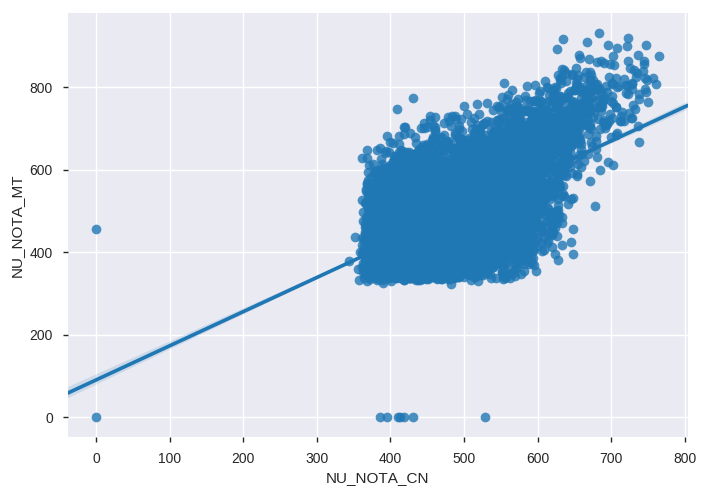

In [4]:
sns.regplot(x="NU_NOTA_CN", y="NU_NOTA_MT", data=data_train)
#sns.pairplot(data_train)

### Remove Outliers

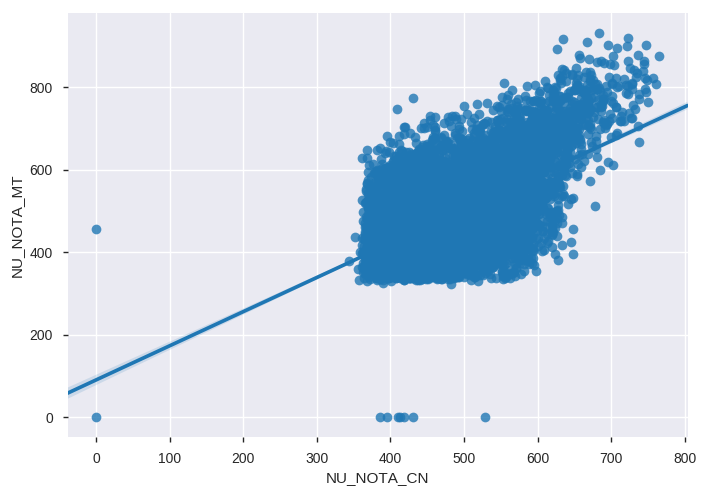

In [5]:
clean_data_train = (
    data_train
#     [(data_train.NU_NOTA_CN - data_train.NU_NOTA_CN.mean()).abs() < 3*data_train.NU_NOTA_CN.std()]
#     [(data_train.NU_NOTA_CH - data_train.NU_NOTA_CH.mean()).abs() < 3*data_train.NU_NOTA_CH.std()]
#     [(data_train.NU_NOTA_LC - data_train.NU_NOTA_LC.mean()).abs() < 3*data_train.NU_NOTA_LC.std()]
#     [(data_train.NU_NOTA_REDACAO - data_train.NU_NOTA_REDACAO.mean()).abs() < 3*data_train.NU_NOTA_REDACAO.std()]
#     [(data_train.NU_NOTA_MT - data_train.NU_NOTA_MT.mean()).abs() < 3*data_train.NU_NOTA_MT.std()]
)
sns.regplot(x="NU_NOTA_CN", y="NU_NOTA_MT", data=clean_data_train)

### Create regression model
- Separate data for train and test randomly
- Create model fitting the training data
- Evaluate the model with testing data
- Measure performance with coefficient of determination (0 to 1 scale)

In [64]:
x_train, x_test, y_train, y_test = train_test_split(
    clean_data_train[feature_cols], clean_data_train[target_col], test_size=0.3, random_state=42)

#### Linear Regression

In [65]:
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
metrics.explained_variance_score(y_test, y_pred)

0.40815469713193364

#### GradientBoostingRegressor

In [ ]:
params = {'n_estimators': 2000, 'max_depth': 3, 'min_samples_split': 50,
          'learning_rate': 0.01, 'loss': 'lad'}
model = ensemble.GradientBoostingRegressor(**params)
model.fit(x_train, y_train.values.ravel())
y_pred = model.predict(x_test)
metrics.explained_variance_score(y_test, y_pred)

#### DecisionTreeRegressor

In [33]:
model = tree.DecisionTreeRegressor(max_depth=4)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
metrics.explained_variance_score(y_test, y_pred)

0.43212269395064995

### Generate submission answer
- Complete with NaN if there is a NaN value in some column
- Make prediction using the regression model
- Create python dict and convert to json file

In [69]:
result_nan = (
    data_to_predict[data_to_predict.isna().any(axis=1)]
    .assign(NU_NOTA_MT=lambda df: 0)
    [["NU_INSCRICAO", "NU_NOTA_MT"]]
)
result_no_nan = (
    data_to_predict.dropna()
    .assign(NU_NOTA_MT=lambda df: model.predict(df[feature_cols]))
    [["NU_INSCRICAO", "NU_NOTA_MT"]]
)
answer = result_no_nan.to_dict("records") + result_nan.to_dict("records")
submission = {
    "token": "5cfb5e6838b5b71058949df3e8746d3ff1c31a73",
    "email": "igor.a.r.y@gmail.com",
    "answer": answer
}
with open("submission.json", "w") as fp:
    json.dump(submission, fp)

### Send Post request to codenation API

In [70]:
url = 'https://api.codenation.com.br/v1/user/acceleration/data-science/challenge/enem-2/submit'
r = requests.post(url, json=submission)
r.json()

{'score': 90.30826433805383}